Power Method
-------------

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
#import sklearn.datasets as skdata
from scipy.stats import ortho_group
from numpy import linalg as LA
import os


In [2]:

def power_step(A, w0):
    """Computes one step in power method to compute an approximation for dominant
    eigenpair of A"""
    w = A@w0
    norm = LA.norm(w)
    w = w/norm
    mu = w.T@A@w
    return mu, w

def power_method(A, n_iterations: int):
    """A slightly modified version of
    the function power_iteration retrieved from 
    https://en.wikipedia.org/wiki/Power_iteration
    (Retrieved: 8.9.2022)
    Function computes n_iterations of power_method 
    and returns the dominant eigenpair of each step"""

    dimA = A.shape[1]

    #initialize
    W_T = np.zeros((n_iterations, dimA))
    mus = np.zeros(n_iterations)
    w0 = np.random.rand(dimA)
    norm = LA.norm(w0)
    #normalize
    w0 = w0 / norm


    #assign values in row order bc numpy row major
    for i in np.arange(n_iterations):
        mui, wi = power_step(A, w0)
        mus[i] = mui
        W_T[i,:] = wi
        w0 = wi
 
    return mus, W_T


def hotelling(A, v, mu, n_iterations):
    """Function to compute the second eigenvector after the largest
    eigenvalue and corresponding eigenvector has been computed.
    Function utilizes Hotelling's method.
    Parameters:
    A : 2D array
    v : 1D array. Approximated eigenvector corresponding to the approximated largest eigenvalue of A. 
    a : float. Approximation of largest eigenvalue of A.
    n_iterations : int"""

    dimA = A.shape[1]
    W_T = np.zeros((n_iterations, dimA))
    mus = np.zeros(n_iterations)
    w0 = np.random.rand(dimA)
    norm = LA.norm(w0)
    #normalize
    w0 = w0 / norm

    for i in np.arange(n_iterations):
        wi = A@w0-mu*(v.T@w0)*v
        norm = LA.norm(wi)
        #normalize
        wi = wi / norm
        mui = wi.T@A@wi
        mus[i] = mui
        W_T[i,:] = wi
        w0 = wi
        

    return mus, W_T




def err_mus(mu_exact, mu_approxs):
    exacts = np.repeat(mu_exact, len(mu_approxs))
    return abs(exacts-mu_approxs)

def err_w(w_approx, w_exact):
    """Helper 1-D function to map with err_ws. Note the order of parameters."""
    err = min(LA.norm(w_exact-w_approx), LA.norm(-w_exact-w_approx)) #could converge to -x1 which also eigvec
    return err



def err_WT(w_exact, WT):
    err_WT = np.apply_along_axis(err_w, 1, WT, w_exact=w_exact)
    return err_WT


def create_dataset(mu1s, mu2s, err_mu1s, err_mu2s, err_WT1s, err_WT2s, matrix_dim, eigengap):
    out = xr.Dataset(
        data_vars={"mu1s": (["run", "iteration"], mu1s),
                   "mu2s": (["run", "iteration"], mu2s),
                    "err_mu1s": (["run", "iteration"], err_mu1s),
                   "err_mu2s": (["run", "iteration"], err_mu2s),
                   "err_WT1s": (["run", "iteration"], err_WT1s),
                   "err_WT2s": (["run", "iteration"], err_WT2s)},
        attrs={'comment': f"Absolute errors in {err_mu1s.shape[0]} runs of power method with matrix dimension {matrix_dim}, and eigengaps {eigengap}"}
    )
    return out


Random matrices for numerical examples
--------------------------------------

In [3]:



def create_QDQT(n:int, eigs:list):
    Q = ortho_group.rvs(n)
    D = np.diag(eigs)
    return Q@D@Q.T

In [35]:
n = 100 # matrix dimension

#predefined eigenvalues
eigengap = 0.05 #gap between lambda_1 and lambda_2 & lambda_2 & others


top2 =  [1.0, 1.0-eigengap]
others = 1.0-eigengap*2



eigs = np.repeat(others, n)
eigs[0:2] = top2
print(eigs)


K = 100 #how many iterations for power_method
n_runs = 1000 #how many runs with different matrix with similar eigenstructure




mu1s = np.zeros([n_runs, K])
mu2s = np.zeros([n_runs, K])
err_mu1s = np.zeros([n_runs, K])
err_mu2s = np.zeros([n_runs, K])
err_WT1s = np.zeros([n_runs, K])
err_WT2s = np.zeros([n_runs, K])


for i in np.arange(n_runs):

    
    #generate new random matrix with similar eigenstructure
    M = create_QDQT(n, eigs)

    #exact eigenvals and eigenvecs
    evals, evecs = LA.eigh(M)
    lam1 = evals[-1]
    lam2 = evals[-2]
    x1 = evecs[:,-1]
    x2 = evecs[:,-2]

    mu1s_i, WT1_i = power_method(M, K)
    mu2s_i, WT2_i = hotelling(M, WT1_i[-1], mu1s_i[-1], K)

    #absolute errors of run i
    err_mu1s_i = err_mus(lam1, mu1s_i)
    err_mu2s_i = err_mus(lam2, mu2s_i)

    err_WT1_i = err_WT(x1, WT1_i)
    err_WT2_i = err_WT(x2, WT2_i)


    #assemble into arrays with row i = run i of power method, col j = jth iteration
    mu1s[i,:] = mu1s_i
    mu2s[i,:] = mu2s_i


    err_mu1s[i, :] = err_mu1s_i
    err_mu2s[i, :] = err_mu2s_i

    err_WT1s[i, :] = err_WT1_i
    err_WT2s[i, :] = err_WT2_i

#save as netCDF
OUTPUT_PATH = '/home/pietaril/Documents/data/powermethod_data/'
output_filename = f"powerset_eigengap_{eigengap}.nc"
out = create_dataset(mu1s, mu2s, err_mu1s, err_mu2s, err_WT1s, err_WT2s, n, eigengap)
out.to_netcdf(os.path.join(OUTPUT_PATH, output_filename))
    





[1.   0.95 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.9
 0.9  0.9 ]


In [11]:
A = np.ones((2,2))
A[1,:] = 2
A

array([[1., 1.],
       [2., 2.]])

In [14]:
np.mean(A, 0)

array([1.5, 1.5])

In [2]:
def get_err_stats(DATAPATH, eiggap):
    """Compute statistics of power method run errors for each iteration"""

    ds = xr.open_dataset(f"{DATAPATH}powerset_eigengap_{eiggap}.nc")
    stats = {}
    for key in ["err_mu1s", "err_mu2s", "err_WT1s", "err_WT2s"]:
        errs = ds[key].values
        stats[key] = [np.min(errs, 0), np.mean(errs,0), np.max(errs,0)]
    return stats

def get_mu_stats(DATAPATH, eiggap):
    """Compute statistics of power method runs for each iteration"""

    ds = xr.open_dataset(f"{DATAPATH}powerset_eigengap_{eiggap}.nc")
    stats = {}
    for key in ["mu1s", "mu2s"]:
        mus = ds[key].values
        stats[key] = [np.min(mus, 0), np.mean(mus,0), np.max(mus,0)]
    return stats

DATAPATH = '/home/pietaril/Documents/data/powermethod_data/'

da0_stats = get_err_stats(DATAPATH, 0.2)
da1_stats = get_err_stats(DATAPATH, 0.1)
da2_stats = get_err_stats(DATAPATH, 0.05)


da1_mus = get_mu_stats(DATAPATH, 0.1)
da2_mus = get_mu_stats(DATAPATH, 0.05)

In [3]:
ds0 = xr.open_dataset(f"{DATAPATH}powerset_eigengap_{0.2}.nc")
ds1 = xr.open_dataset(f"{DATAPATH}powerset_eigengap_{0.1}.nc")
ds2 = xr.open_dataset(f"{DATAPATH}powerset_eigengap_{0.05}.nc")

In [5]:
ds1

<xarray.Dataset>
Dimensions:   (run: 1000, iteration: 100)
Dimensions without coordinates: run, iteration
Data variables:
    mu1s      (run, iteration) float64 ...
    mu2s      (run, iteration) float64 ...
    err_mu1s  (run, iteration) float64 ...
    err_mu2s  (run, iteration) float64 ...
    err_WT1s  (run, iteration) float64 ...
    err_WT2s  (run, iteration) float64 ...
Attributes:
    comment:  Absolute errors in 1000 runs of power method with matrix dimens...

In [8]:
da2_stats["err_WT2s"]

[array([1.12662119e+00, 1.09184830e+00, 1.05367272e+00, 1.01208863e+00,
        9.67209728e-01, 9.19291290e-01, 8.68742135e-01, 8.16120983e-01,
        7.62114020e-01, 7.07494247e-01, 6.53067777e-01, 5.99615773e-01,
        5.47841809e-01, 4.98332559e-01, 4.51535912e-01, 4.07756357e-01,
        3.67164306e-01, 3.29814530e-01, 2.95668914e-01, 2.64619714e-01,
        2.36510811e-01, 2.11155672e-01, 1.88351620e-01, 1.67890595e-01,
        1.49566858e-01, 1.33182224e-01, 1.18549372e-01, 1.05493727e-01,
        9.38543076e-02, 8.34838733e-02, 7.42485850e-02, 6.60273744e-02,
        5.87111362e-02, 5.22018350e-02, 4.64115841e-02, 4.12617372e-02,
        3.66820166e-02, 3.26096928e-02, 2.89888228e-02, 2.57695504e-02,
        2.29074683e-02, 2.03630397e-02, 1.81010757e-02, 1.60902659e-02,
        1.43027567e-02, 1.27137737e-02, 1.13012844e-02, 1.00456966e-02,
        8.92958968e-03, 7.93747489e-03, 7.05558175e-03, 6.27166801e-03,
        5.57485039e-03, 4.95545395e-03, 4.40487814e-03, 3.915477

In [50]:
aaaa= da2_stats["err_mu1s"][0]

np.vstack((aaaa, aaaa)).shape

(2, 100)

## Error plots

Looks like it's maybe better to have separate plots for eigenval & eigenvec errors since scales differ a lot

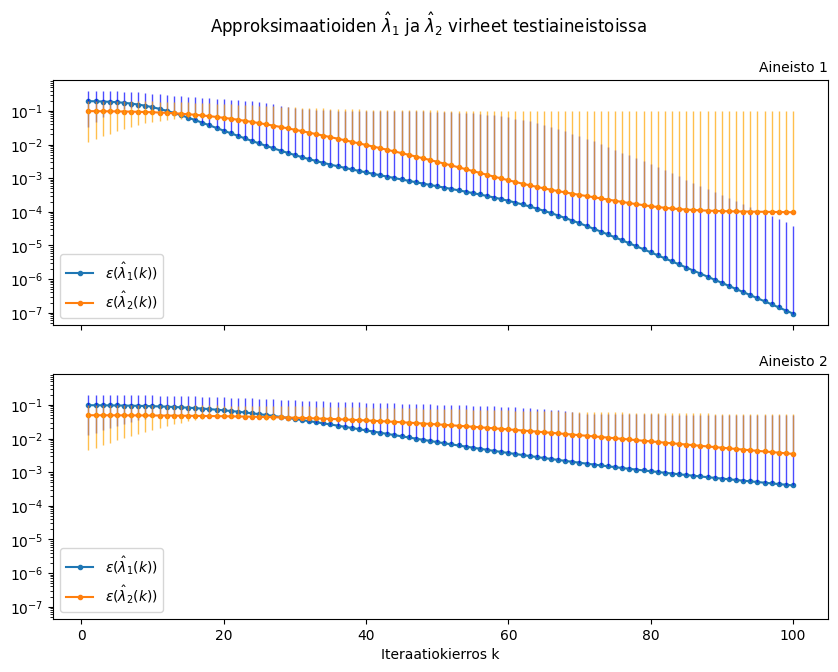

In [4]:
import matplotlib.pyplot as plt

#eigenvalue convergence
K = 100


data =  [da1_stats, da2_stats]

colors = ["blue", "orange"]
keys =  ["err_mu1s", "err_mu2s"]

fig, axs = plt.subplots(2,1, figsize = (10,7), sharey = True)
for i in range(2):
    da = data[i]
    #axs[i].set_ylabel("Virheen suuruus")
    axs[i].set_title(f"Aineisto {i+1}", loc="right", fontsize=10)
    for j in range(2):
        key = keys[j]
        yerr = np.vstack((da[key][0], da[key][2]))
        axs[i].plot(np.arange(1,K+1), da[key][1], marker = '.', label = f"$ \epsilon ( \hat \lambda_{j+1} (k)) $")
        #axs[i].fill_between(np.arange(1,K+1), da[key][0], da[key][2], alpha = 0.2)
        axs[i].errorbar(np.arange(1,K+1), da[key][1], yerr=yerr, fmt='none', linewidth= 1.5, color = colors[j],alpha = 0.7, elinewidth = 1)# label = f"$ \epsilon ( \hat \lambda_{key[-2]} ) $" 
        axs[i].legend(loc = 'lower left')
        axs[i].set_yscale('log')
    #axs[i].text(0.2, 0.2, f"Aineisto {i+1}")
axs[1].set_xlabel("Iteraatiokierros k")
axs[0].set_xticklabels([])
fig.suptitle(f"Approksimaatioiden $\hat \lambda_{1}$ ja $\hat \lambda_2$ virheet testiaineistoissa")

    
plt.show()

In [15]:
len(da1_stats["err_mu1s"])

3

At which iteration is the mean mu1 error smaller than that of mu2

In [26]:
diffs1 = da1_stats["err_mu2s"][1] - da1_stats["err_mu1s"][1]
np.where(diffs1 > 0)



(array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
        30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80,
        81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
        98, 99]),)

In [27]:
diffs2 = da2_stats["err_mu2s"][1] - da2_stats["err_mu1s"][1]
np.where(diffs2 > 0)


(array([28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
        45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
        62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
        79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
        96, 97, 98, 99]),)

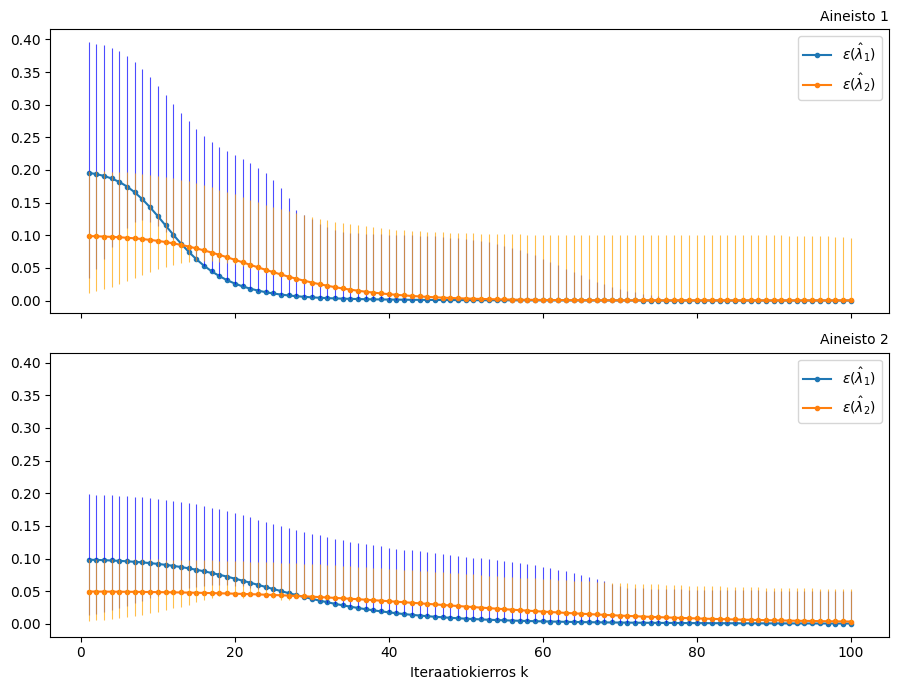

In [37]:


#eigenvalue convergence
K = 100


data =  [da1_stats, da2_stats]

colors = ["blue", "orange"]
keys =  ["err_mu1s", "err_mu2s"]

fig, axs = plt.subplots(2,1, figsize = (9,7), sharey = True, tight_layout = True)
for i in range(2):
    da = data[i]
    axs[i].set_title(f"Aineisto {i+1}", fontsize=10, loc='right')
    #axs[i].set_ylabel("Virheen suuruus")
    for j in range(2):
        key = keys[j]
        yerr = np.vstack((da[key][0], da[key][2]))
        axs[i].plot(np.arange(1,K+1), da[key][1], marker = '.', label = f"$ \epsilon ( \hat \lambda_{j+1}) $")
        #axs[i].fill_between(np.arange(1,K+1), da[key][0], da[key][2], alpha = 0.2)
        axs[i].errorbar(np.arange(1,K+1), da[key][1], yerr=yerr, fmt='none', linewidth= 1.5, color = colors[j],alpha = 0.7, elinewidth = 0.8)# label = f"$ \epsilon ( \hat \lambda_{key[-2]} ) $" 
        axs[i].legend()
        #axs[i].set_yscale('log')
axs[1].set_xlabel("Iteraatiokierros k", fontsize = 10)
axs[0].set_xticklabels([])


    
plt.show()

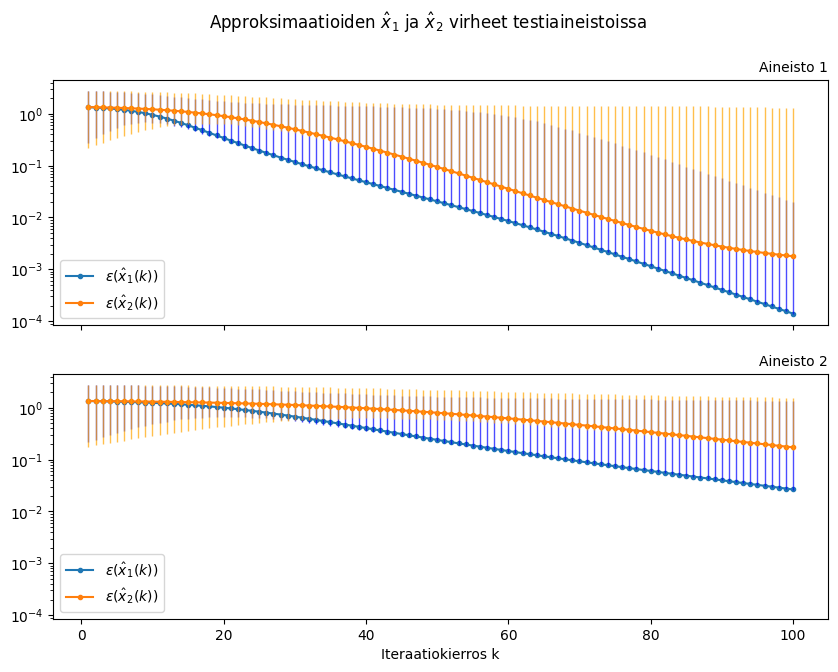

In [5]:
#eigenvector convergence


keys = ["err_WT1s", "err_WT2s"]

fig, axs = plt.subplots(2,1, figsize = (10,7), sharey = True, sharex = True)
for i in range(2):
    da = data[i]
    axs[i].set_title(f"Aineisto {i+1}", loc="right", fontsize=10)
    for j in range(2):
        key = keys[j]
        yerr = np.vstack((da[key][0], da[key][2]))
        axs[i].plot(np.arange(1,K+1), da[key][1], marker = '.', label = f"$ \epsilon ( \hat x_{j+1}(k) ) $")
        #axs[i].fill_between(np.arange(1,K+1), da[key][0], da[key][2], alpha = 0.2)
        axs[i].errorbar(np.arange(1,K+1), da[key][1], yerr=yerr, fmt='none', linewidth= 1.5, color = colors[j],alpha = 0.7, elinewidth = 1)# label = f"$ \epsilon ( \hat \lambda_{key[-2]} ) $" 
        axs[i].legend(loc='lower left')
        axs[i].set_yscale('log')
axs[1].set_xlabel("Iteraatiokierros k")
#axs[0].set_xticklabels([])
fig.suptitle(f"Approksimaatioiden $\hat x_{1}$ ja $\hat x_2$ virheet testiaineistoissa")
plt.show()

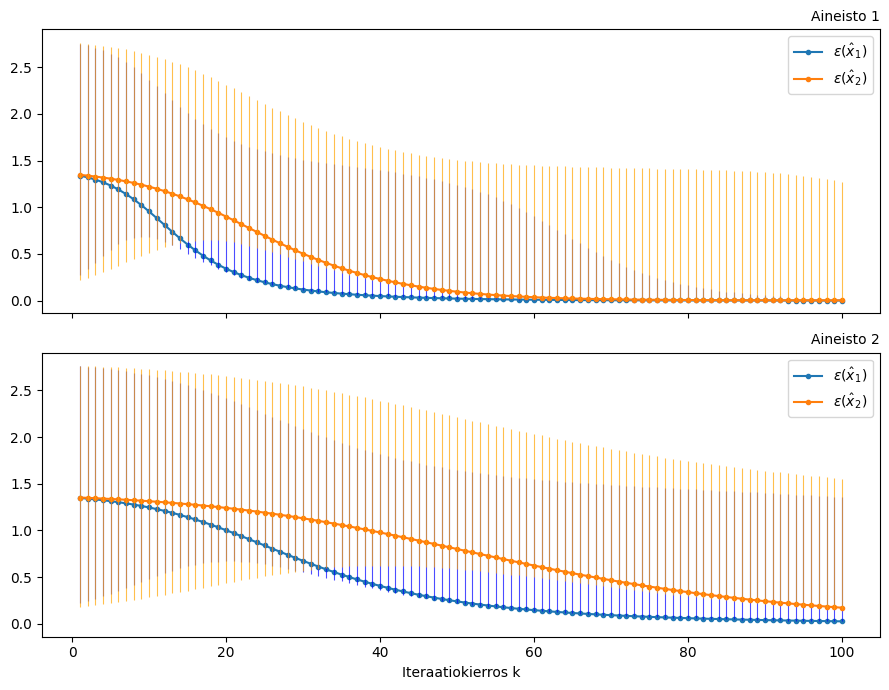

In [31]:
keys = ["err_WT1s", "err_WT2s"]

fig, axs = plt.subplots(2,1, figsize = (9,7), sharey = True, sharex = True, tight_layout = True)
for i in range(2):
    da = data[i]
    for j in range(2):
        key = keys[j]
        yerr = np.vstack((da[key][0], da[key][2]))
        axs[i].plot(np.arange(1,K+1), da[key][1], marker = '.', label = f"$ \epsilon ( \hat x_{j+1} ) $")
        #axs[i].fill_between(np.arange(1,K+1), da[key][0], da[key][2], alpha = 0.2)
        axs[i].errorbar(np.arange(1,K+1), da[key][1], yerr=yerr, fmt='none', linewidth= 1.5, color = colors[j],alpha = 0.7, elinewidth = 0.8)# label = f"$ \epsilon ( \hat \lambda_{key[-2]} ) $" 
        axs[i].legend()
        axs[i].set_title(f"Aineisto {i+1}", fontsize=10, loc='right')
        #axs[i].set_yscale('log')
    axs[1].set_xlabel("Iteraatiokierros k", fontsize = 10)
    
plt.show()

## Mu plots

In [ ]:

#eigenvalue convergence
K = 100


data =  [da1_mus, da2_mus]

colors = ["blue", "orange"]
keys =  ["mu1s", "mu2s"]

fig, axs = plt.subplots(2,1, figsize = (9,7), sharey = True)
for i in range(2):
    da = data[i]
    #axs[i].set_ylabel(f"")
    for j in range(2):
        key = keys[j]
        yerr = np.vstack((da[key][0], da[key][2]))
        axs[i].plot(np.arange(1,K+1), da[key][1], marker = '.', label = f"$ \hat \lambda_{j+1}(k) $")
        #axs[i].fill_between(np.arange(1,K+1), da[key][0], da[key][2], alpha = 0.2)
        axs[i].errorbar(np.arange(1,K+1), da[key][1], yerr=yerr, fmt='none', linewidth= 1.5, color = colors[j],alpha = 0.7, elinewidth = 0.8)# label = f"$ \epsilon ( \hat \lambda_{key[-2]} ) $" 
        axs[i].legend()
        axs[i].set_yscale('log')
    axs[i].text(10, 0.38, f"Datasetti {i+1}")
axs[1].set_xlabel("Iteraatiokierros k")
axs[0].set_xticklabels([])
fig.suptitle("")

    
plt.show()

In [7]:

import matplotlib.pyplot as plt

whichruns = np.randint()
labels = [r'$\lambda_1$', r'$\lambda_2$']

mu1s = ds1["mu1s"]
mu2s = ds1["mu2s"]
mus = [mu1s, mu2s]

fig, axs = plt.subplots(2,1, figsize = (10,8), sharex='col')
for i in range(2):
    for j in range(n_runs):

       # axs[i].plot(np.arange(1, K+1), mus[i][j][:], marker = '.', linewidth = 0.8, markersize = 1.2)
    axs[i].axhline(y=evals[-(i+1)], linestyle = 'dashed', color = 'grey')
    axs[i].set_ylabel(f"Estimoitu {labels[i]}")
axs[1].set_xlabel("Iteraatio")
#axs[1].set_xticks(np.arange(1, K+1))
fig.suptitle(f"Potenssiinkorotusmetodin approksimoimat kaksi suurinta testimatriisin ({n} x {n}) ominaisarvoa")
plt.tight_layout
plt.show()

IndentationError: expected an indented block after 'for' statement on line 12 (76868234.py, line 15)

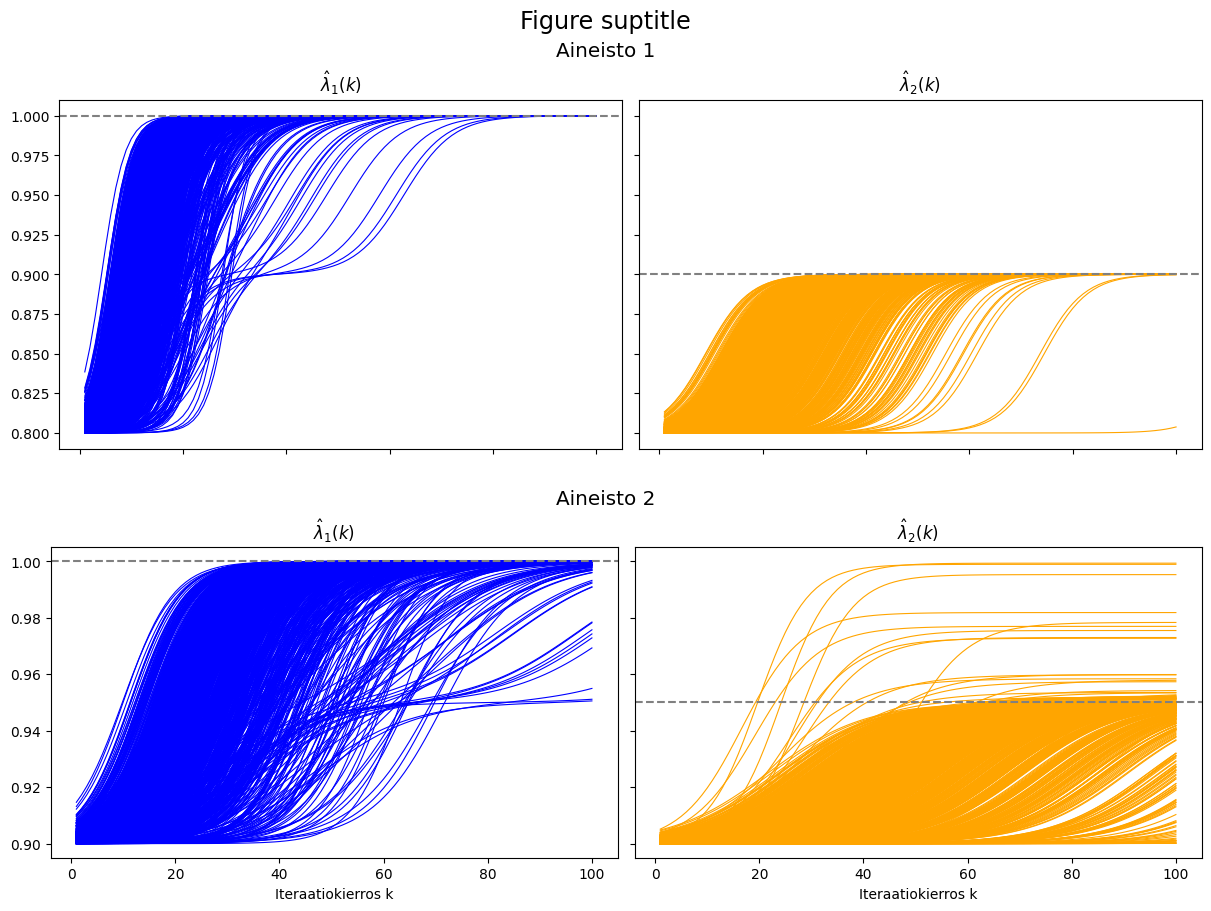

In [10]:

colors = ['blue', 'orange']
labels = [r'$\hat{\lambda}_1(k)$', r'$\hat{\lambda}_2(k)$']
n_runs = 1000
K = 100


fig = plt.figure(layout='constrained', figsize=(12, 9))
subfigs = fig.subfigures(2, 1, hspace=0.06)

axsTop = subfigs[0].subplots(1, 2, sharey=True)

mu1s = ds1["mu1s"]
mu2s = ds1["mu2s"]
mus = [mu1s, mu2s]
evals = [1, 0.9]

#subfigs[0].set_facecolor('0.75')
for i, ax in enumerate(axsTop):
    for j in range(n_runs):
        ax.plot(np.arange(1, K+1), mus[i][j][:], color = colors[i], linewidth = 0.8)
    ax.axhline(y=evals[i], linestyle = 'dashed', color = 'grey')
    #ax.set_ylabel(labels[i])
    ax.set_xticklabels([])
    ax.set_title(labels[i])
    
    #ax.set_xlabel("Iteraatiokierros k")
    
subfigs[0].suptitle('Aineisto 1', fontsize='x-large')

mu1s = ds2["mu1s"]
mu2s = ds2["mu2s"]
mus = [mu1s, mu2s]
evals = [1, 0.95]

axsBottom = subfigs[1].subplots(1, 2, sharey=True)
for i, ax in enumerate(axsBottom):
    for j in range(n_runs):
        ax.plot(np.arange(1, K+1), mus[i][j][:], color = colors[i], linewidth = 0.8)
    ax.axhline(y=evals[i], linestyle = 'dashed', color = 'grey')
    #ax.set_ylabel(labels[i])
    ax.set_xlabel("Iteraatiokierros k")
    ax.set_title(labels[i])
    
subfigs[1].suptitle('Aineisto 2', fontsize='x-large')


fig.suptitle('Figure suptitle', fontsize='xx-large')

plt.show()

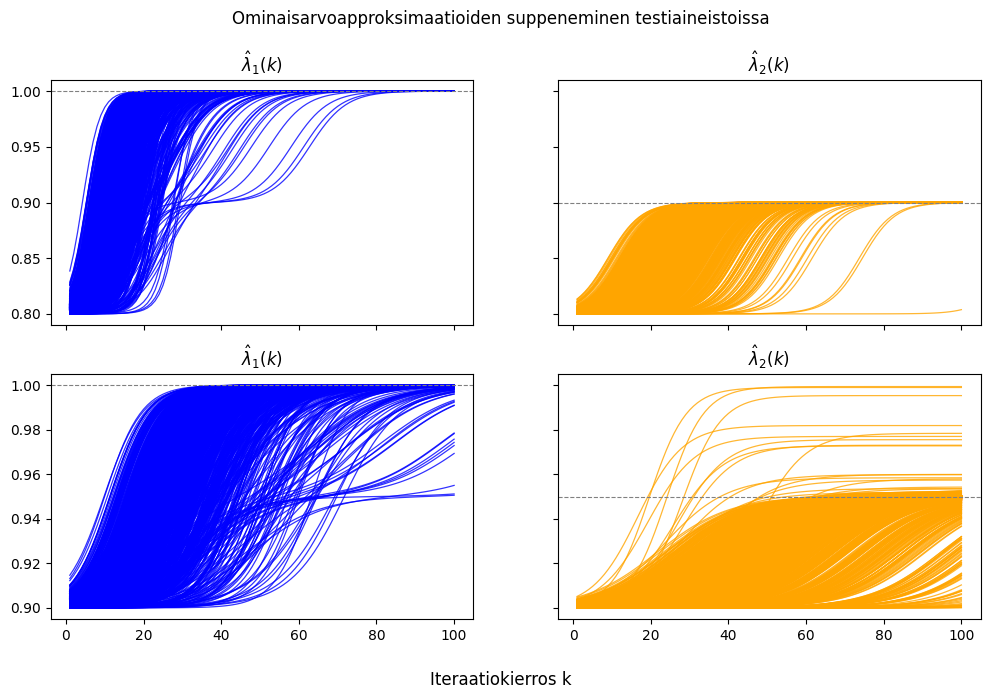

In [11]:


labels = [r'$\hat{\lambda}_1(k)$', r'$\hat{\lambda}_2(k)$']
n_runs = 1000
colors = ['blue', 'orange']


datasets = [ds1, ds2]

fig, axs = plt.subplots(2,2, figsize = (12,7), sharex='col', sharey='row')
for k in range(2):
    ds = datasets[k]
    mus = [ds["mu1s"], ds["mu2s"]]
    if k == 0:
        evals = [1, 0.9]
    else:
        evals = [1, 0.95]
    for i in range(2):
        axs[k, i].set_title(f"{labels[i]}")
        for j in range(n_runs):
            axs[k, i].plot(np.arange(1, K+1), mus[i][j][:], color = colors[i], alpha = 0.8, linewidth = 0.9)
        axs[k, i].axhline(y=evals[i], linestyle = 'dashed', color = 'grey', linewidth = 0.8)
            
    
    
    
#axs[1,0].set_xlabel("Iteraatiokierros k")
#axs[1,1].set_xlabel("Iteraatiokierros k")
#axs[1].set_xticks(np.arange(1, K+1))
fig.supxlabel("Iteraatiokierros k")
fig.suptitle(f"Ominaisarvoapproksimaatioiden suppeneminen testiaineistoissa")
plt.show()

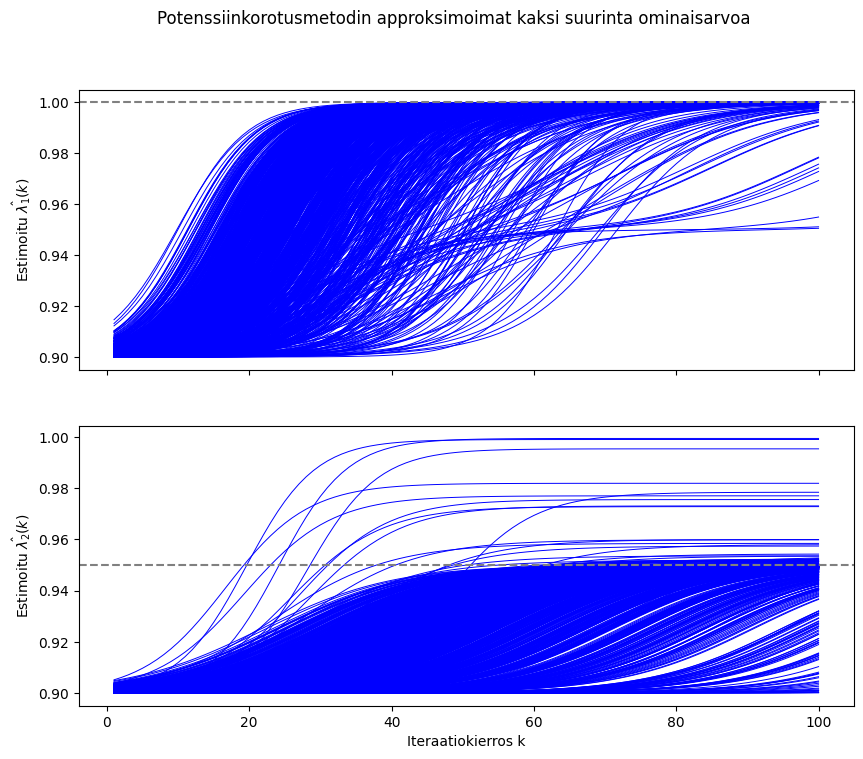

In [13]:
labels = [r'$\hat{\lambda}_1(k)$', r'$\hat{\lambda}_2(k)$']
n_runs = 1000
mu1s = ds2["mu1s"]
mu2s = ds2["mu2s"]
mus = [mu1s, mu2s]
evals = [1, 0.95]

fig, axs = plt.subplots(2,1, figsize = (10,8), sharex='col')
for i in range(2):
    for j in range(n_runs):
        axs[i].plot(np.arange(1, K+1), mus[i][j][:], color = 'b', linewidth = 0.7)
    axs[i].axhline(y=evals[i], linestyle = 'dashed', color = 'grey')
    axs[i].set_ylabel(f"Estimoitu {labels[i]}")
axs[1].set_xlabel("Iteraatiokierros k")
#axs[1].set_xticks(np.arange(1, K+1))
fig.suptitle(f"Potenssiinkorotusmetodin approksimoimat kaksi suurinta ominaisarvoa")
plt.tight_layout
plt.show()

In [18]:
mus, vs, errs = power_method_thresh(M, 1e-5, maxiter=1000)


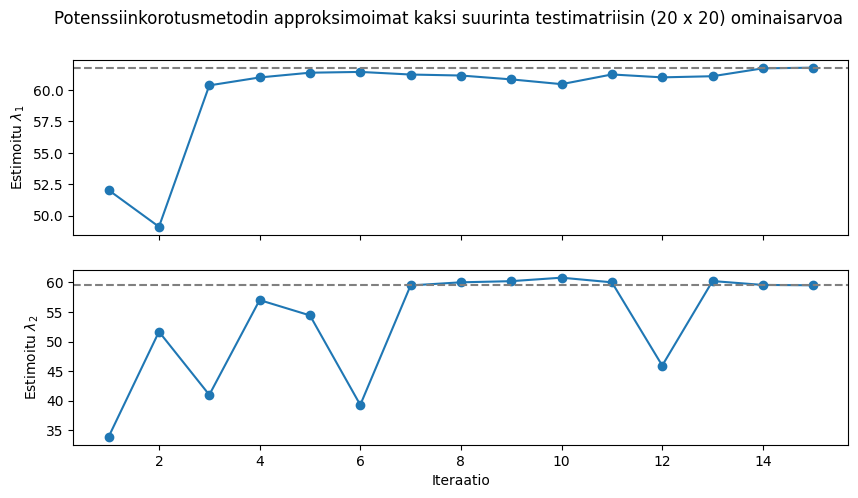

11.694825610284667
